<a href="https://colab.research.google.com/github/pal-ette/iNotePal/blob/%236-%EA%B0%90%EC%84%B1%EB%8C%80%ED%99%94/models/%EA%B0%90%EC%84%B1%EB%8C%80%ED%99%94_KoBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mxnet-mkl==1.6.0 numpy==1.23.1

In [ ]:
!pip install mxnet
!pip install gluonnlp==0.10.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch

In [ ]:
# KoBERT
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-x1rhsc8q/kobert-tokenizer_94a30c7bf52e4f7384d33231162472b6
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-x1rhsc8q/kobert-tokenizer_94a30c7bf52e4f7384d33231162472b6
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import tqdm

In [ ]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
device = torch.device("cuda:0")

# Load Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/chatbot/감성대화.csv')
df

,Unnamed: 0,감정_대분류,사람문장1,사람문장2,Emotion
0,0,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.,그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.,1.0
1,1,분노,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.,1.0
2,2,분노,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,잘 안 맞는 사람이랑 억지로 잘 지내는 것보단 조금은 거리를 두고 예의를 갖춰서 대...,1.0
3,3,분노,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,직장 사람들과 솔직하게 이야기해보고 싶어. 일하는 데에 방해된다고.,1.0
4,4,분노,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,상사인 나에게 먼저 인사하지 않아서 매일 내가 먼저 인사한다고!,1.0
...,...,...,...,...,...
58266,58266,당황,나랑 비슷한 시기에 결혼하는 친구는 시댁에서 집을 해줘서 너무 부러워. 우리는 대출...,우리만 뒤처지는 것 같고. 그래도 열심히 살다 보면 우리도 집을 살 수 있겠지?,4.0
58267,58267,당황,친구 한 명이 결혼해서 아이를 가졌는데 너무 행복해 보이더라. 기분이 좋지만은 않아.,나도 결혼했지만 아이도 생기지 않고 그 정도로 행복하지 않거든. 친구보다 못사는 것...,4.0
58268,58268,당황,남들은 결혼 전에 일억을 모았다는데 난 뭐를 한 것인지 모르겠어. 자괴감만 드네.,요새 집값이 너무 올라서 한숨만 나와.,4.0
58269,58269,당황,나보다 결혼을 먼저 한 친구가 부러워. 그 친구 남편은 직장도 내 남편보다 좋고 키...,맞아. 그 친구와 비교하게 되니 자존감이 낮아지는 기분이야.,4.0


In [ ]:
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,감정_대분류,사람문장1,사람문장2,Emotion
0,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.,그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.,1.0
1,분노,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.,1.0
2,분노,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,잘 안 맞는 사람이랑 억지로 잘 지내는 것보단 조금은 거리를 두고 예의를 갖춰서 대...,1.0
3,분노,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,직장 사람들과 솔직하게 이야기해보고 싶어. 일하는 데에 방해된다고.,1.0
4,분노,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,상사인 나에게 먼저 인사하지 않아서 매일 내가 먼저 인사한다고!,1.0


In [ ]:
df['사람문장'] = df['사람문장1'] + df['사람문장2']
df

,감정_대분류,사람문장1,사람문장2,Emotion,사람문장
0,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.,그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.,1.0,일은 왜 해도 해도 끝이 없을까? 화가 난다.그냥 내가 해결하는 게 나아. 남들한테...
1,분노,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.,1.0,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나....
2,분노,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,잘 안 맞는 사람이랑 억지로 잘 지내는 것보단 조금은 거리를 두고 예의를 갖춰서 대...,1.0,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3,분노,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,직장 사람들과 솔직하게 이야기해보고 싶어. 일하는 데에 방해된다고.,1.0,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4,분노,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,상사인 나에게 먼저 인사하지 않아서 매일 내가 먼저 인사한다고!,1.0,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.상사인 나에게 먼...
...,...,...,...,...,...
58266,당황,나랑 비슷한 시기에 결혼하는 친구는 시댁에서 집을 해줘서 너무 부러워. 우리는 대출...,우리만 뒤처지는 것 같고. 그래도 열심히 살다 보면 우리도 집을 살 수 있겠지?,4.0,나랑 비슷한 시기에 결혼하는 친구는 시댁에서 집을 해줘서 너무 부러워. 우리는 대출...
58267,당황,친구 한 명이 결혼해서 아이를 가졌는데 너무 행복해 보이더라. 기분이 좋지만은 않아.,나도 결혼했지만 아이도 생기지 않고 그 정도로 행복하지 않거든. 친구보다 못사는 것...,4.0,친구 한 명이 결혼해서 아이를 가졌는데 너무 행복해 보이더라. 기분이 좋지만은 않아...
58268,당황,남들은 결혼 전에 일억을 모았다는데 난 뭐를 한 것인지 모르겠어. 자괴감만 드네.,요새 집값이 너무 올라서 한숨만 나와.,4.0,남들은 결혼 전에 일억을 모았다는데 난 뭐를 한 것인지 모르겠어. 자괴감만 드네.요...
58269,당황,나보다 결혼을 먼저 한 친구가 부러워. 그 친구 남편은 직장도 내 남편보다 좋고 키...,맞아. 그 친구와 비교하게 되니 자존감이 낮아지는 기분이야.,4.0,나보다 결혼을 먼저 한 친구가 부러워. 그 친구 남편은 직장도 내 남편보다 좋고 키...


In [ ]:
df1 = df.copy()
df1 = df1.drop(['사람문장1', '사람문장2'], axis=1)
df1


,감정_대분류,Emotion,사람문장
0,분노,1.0,일은 왜 해도 해도 끝이 없을까? 화가 난다.그냥 내가 해결하는 게 나아. 남들한테...
1,분노,1.0,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나....
2,분노,1.0,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3,분노,1.0,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4,분노,1.0,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.상사인 나에게 먼...
...,...,...,...
58266,당황,4.0,나랑 비슷한 시기에 결혼하는 친구는 시댁에서 집을 해줘서 너무 부러워. 우리는 대출...
58267,당황,4.0,친구 한 명이 결혼해서 아이를 가졌는데 너무 행복해 보이더라. 기분이 좋지만은 않아...
58268,당황,4.0,남들은 결혼 전에 일억을 모았다는데 난 뭐를 한 것인지 모르겠어. 자괴감만 드네.요...
58269,당황,4.0,나보다 결혼을 먼저 한 친구가 부러워. 그 친구 남편은 직장도 내 남편보다 좋고 키...


### LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df1['label'] = LE.fit_transform(df1['Emotion'])

labels = LE.classes_
print(len(labels), labels)

5 [0. 1. 2. 3. 4.]


In [ ]:
df1['Emotion'].value_counts()

Emotion
4.0    17143
0.0    10433
1.0    10417
2.0    10150
3.0    10128
Name: count, dtype: int64

### Re-arrange Data

In [ ]:
data_list = []
for q1, label in zip(df1['사람문장'], df['Emotion']):
    data = []
    data.append(q1)
    data.append(str(int(label)))

    data_list.append(data)


data


['친구들 모두 결혼하고 나만 혼자 남아서 쓸쓸하네.맞아. 하지만 그렇다고 아무나하고 결혼할 수도 없잖아.', '4']

### Train / Test Split

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_list, test_size=0.25, random_state=0, shuffle=True)

print(len(train), len(test))

43703 14568



# KoBERTTokenizer

In [ ]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


### token length

In [ ]:
train


[['자식들이 결혼하면 주려고 모으던 돈을 내 치료비로 쓰게 되니 너무 슬프고 눈물이 나.내가 그린 인생의 그림이 병 때문에 망가졌어.',
  '3'],
 ['직원 환송회 자리에서 평소 사이가 좋지 않던 직원들이 싸웠어. 너무 당황스러웠어.자주 말다툼하긴 했지만 큰 싸움은 처음이라 매우 당황스러웠어.',
  '0'],
 ['우리 엄마는 새벽까지 잠을 안 자고 공부하는 모습을 지켜봐. 날 못 믿는 거 같아 슬퍼.부담스러워서 공부를 못할 거 같은데 시간표를 만들어 보여줄까 생각 중이야.',
  '3'],
 ['스터디 모이는데 내가 제일 못해서 친구들에게 눈치가 보여.내가 공부를 못해서 뒤쳐지니 몇 명이 나를 도와주고 내게 맞추어 주려고 해.',
  '4'],
 ['우리 집은 어려워서 대학교도 못 갈 거 같아. 나도 대학교 가고 싶은데 힘들다.우리 집 사정이 어려운데 대학교를 가려면 내가 지금 알바라도 해야 할까?',
  '0'],
 ['요즘 취업 시즌이라 동기들 다 걱정이거든. 그렇지만 난 걱정을 덜 할 수 있어서 다행이야.아직은 아니야. 하지만 취직이 거의 확정적으로 보여.',
  '4'],
 ['아침부터 선생님이 나를 보자마자 내 성적이 왜 이러냐며 화를 내셨어. 너무 화가 나.응. 공부 다 때려 치고 싶을정도로 기분이 안 좋아.',
  '1'],
 ['지난주에 머리가 어지러워서 한동안 일어나질 못했어.아니. 뭘 어떻게 해야 할지도 모르겠고 또 금방 나아서 그냥 넘어갔어. ', '3'],
 ['이 나이 되도록 열심히 살아왔지만 낮은 소득 때문에 아직도 힘들다는 게 너무 슬퍼.생각했던 것보다 이루지 못한 게 많아서 슬퍼.',
  '3'],
 ['유능한 신입사원이 와서 너무 기분이 좋고 뿌듯해.왜 승진 시험을 제대로 못 보는지 너무 답답해.', '4'],
 ['결혼 준비 중인데 웨딩플래너가 예비 신랑 전 여자친구야. 뭘 해도 자꾸 나에게 악의적인 것만 같아서 짜증이 나.불편해할 것 같아서 안 했는데 내 결혼이니 나도 편해야 하는 게 맞긴 하다.',
  '1'],


*Todo*  
1.문장 1 문장 2 를 합쳐서 돌린다

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, q_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[q_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
tok = tokenizer.tokenize
max_len = 300

trainset = BERTDataset(train, 0, 1, tok, vocab, max_len, True, False) # 294
testset = BERTDataset(test, 0, 1, tok, vocab, max_len, True, False) # 215

token_len_train = [d[1] for d in trainset]
token_len_test = [d[1] for d in testset]

In [ ]:
print(min(token_len_train), max(token_len_train))
print(min(token_len_test), max(token_len_test))

12 148
13 119


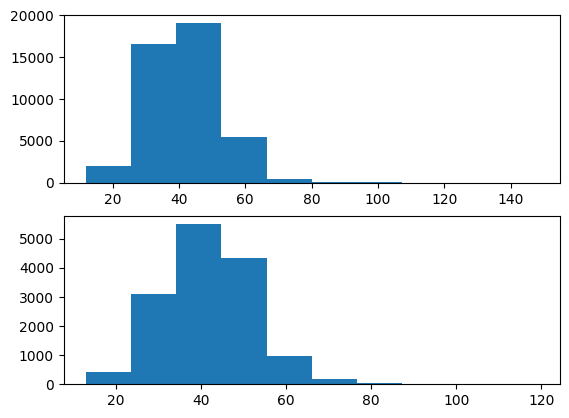

In [ ]:
fig, ax = plt.subplots(2, 1)

ax[0].hist(token_len_train)
ax[1].hist(token_len_test)

plt.show()

### Tokenization

In [ ]:
tok = tokenizer.tokenize
max_len = 64
batch_size = 16

trainset = BERTDataset(train, 0, 1, tok, vocab, max_len, True, False) # 294
testset = BERTDataset(test, 0, 1, tok, vocab, max_len, True, False) # 215

In [ ]:
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

# Model Training

### KoBERT Model

In [ ]:
# get KoBERT model
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [ ]:
# set params
num_classes = len(labels)
num_epochs = 20
warmup_ratio = 0.1
max_grad_norm = 1
log_interval = 200
learning_rate = 0.01

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel, num_classes=num_classes, dr_rate=0.4).to(device)

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

##### Training

In [39]:
best_test_acc = 0.0
best_model = None

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm.notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
    tot_train_acc = train_acc / (batch_id+1)
    print("epoch {} train acc {}".format(e+1, tot_train_acc))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm.notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    tot_acc = test_acc / (batch_id+1)
    print("epoch {} test acc {}".format(e+1, tot_acc))
    if best_test_acc < tot_acc:
      best_test_acc = tot_acc
      best_model = deepcopy(model.state_dict())

  0%|          | 0/2732 [00:00<?, ?it/s]

epoch 1 train acc 0.2585069807571638


  0%|          | 0/911 [00:00<?, ?it/s]

epoch 1 test acc 0.2982985729967069


  0%|          | 0/2732 [00:00<?, ?it/s]

epoch 2 train acc 0.2379568866345953


  0%|          | 0/911 [00:00<?, ?it/s]

epoch 2 test acc 0.2982985729967069


  0%|          | 0/2732 [00:00<?, ?it/s]

epoch 3 train acc 0.22510654151851078


  0%|          | 0/911 [00:00<?, ?it/s]

epoch 3 test acc 0.2982985729967069


  0%|          | 0/2732 [00:00<?, ?it/s]

epoch 4 train acc 0.2234071062539218


  0%|          | 0/911 [00:00<?, ?it/s]

epoch 4 test acc 0.17672886937431395


  0%|          | 0/2732 [00:00<?, ?it/s]

epoch 5 train acc 0.22667851913825562


  0%|          | 0/911 [00:00<?, ?it/s]

epoch 5 test acc 0.2982985729967069


  0%|          | 0/2732 [00:00<?, ?it/s]

epoch 6 train acc 0.2256588579795022


  0%|          | 0/911 [00:00<?, ?it/s]

epoch 6 test acc 0.1763172338090011


  0%|          | 0/2732 [00:00<?, ?it/s]

epoch 7 train acc 0.22699879732273584


  0%|          | 0/911 [00:00<?, ?it/s]

epoch 7 test acc 0.17515093304061471


  0%|          | 0/2732 [00:00<?, ?it/s]

epoch 8 train acc 0.22716874084919472


  0%|          | 0/911 [00:00<?, ?it/s]

epoch 8 test acc 0.17515093304061471


  0%|          | 0/2732 [00:00<?, ?it/s]

epoch 9 train acc 0.23058068395733108


  0%|          | 0/911 [00:00<?, ?it/s]

epoch 9 test acc 0.2982985729967069


  0%|          | 0/2732 [00:00<?, ?it/s]

epoch 10 train acc 0.23552538694833716


  0%|          | 0/911 [00:00<?, ?it/s]

epoch 10 test acc 0.2982985729967069


  0%|          | 0/2732 [00:00<?, ?it/s]

epoch 11 train acc 0.2429734888098724


  0%|          | 0/911 [00:00<?, ?it/s]

epoch 11 test acc 0.2982985729967069


  0%|          | 0/2732 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [40]:
torch.save(model.state_dict(), 'KoBERT_best.pt')

##### Evaluation

In [41]:
def predict(predict_sentence, model, labels):

    data = [predict_sentence]
    label = [0]

    dataset = BERTDataset(data, label, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            print(f'Prediction result : {labels[np.argmax(logits)]}')